In [3]:
%matplotlib inline

In [4]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

Load Data
---------

We will use torchvision and torch.utils.data packages for loading the
data.

The problem we're going to solve today is to train a model to classify
**ants** and **bees**. We have about 120 training images each for ants and bees.
There are 75 validation images for each class. Usually, this is a very
small dataset to generalize upon, if trained from scratch. Since we
are using transfer learning, we should be able to generalize reasonably
well.

This dataset is a very small subset of imagenet.

.. Note ::
   Download the data from
   `here <https://download.pytorch.org/tutorial/hymenoptera_data.zip>`_
   and extract it to the current directory.



In [7]:
from data import BinaryAVA
import matplotlib.pyplot as plt
from torchvision import transforms
import numpy as np
import torch

train_dataset = BinaryAVA('data/AVA_dataset/aesthetics_image_lists/generic_ls_train.jpgl', 
              transform=transforms.Compose([
                  transforms.Resize(256),
                  transforms.CenterCrop(256),
                  transforms.ToTensor()
              ]))

test_dataset = BinaryAVA('data/AVA_dataset/aesthetics_image_lists/generic_test.jpgl', 
              transform=transforms.Compose([
                  transforms.Resize(256),
                  transforms.CenterCrop(256),
                  transforms.ToTensor()
              ]))

### Toggle cell below for sample debugging

In [8]:
train_loader = torch.utils.data.DataLoader(train_dataset,
    batch_size=128, shuffle=True, num_workers=4)
    
test_loader = torch.utils.data.DataLoader(test_dataset,
    batch_size=128, shuffle=True, num_workers=4)

In [9]:
an_item = test_dataset[1]
an_img = an_item[0]
a_label = an_item[1]

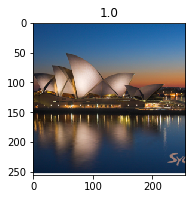

In [10]:
plt.subplot(1,2,1)
plt.title(a_label)
plt.imshow(an_img.numpy().transpose((1,2,0)))

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [15]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(train_loader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
class_names = ['Ugly', 'Beautiful']
imshow(out, title=[class_names[x] for x in classes])

/opt/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 19273 bytes but only got 816. Skipping tag 700
  " Skipping tag %s" % (size, len(data), tag))
/opt/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5140 bytes but only got 816. Skipping tag 34377
  " Skipping tag %s" % (size, len(data), tag))
/opt/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 3144 bytes but only got 816. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag))


TypeError: only integer tensors of a single element can be converted to an index

Training the model
------------------

Now, let's write a general function to train a model. Here, we will
illustrate:

-  Scheduling the learning rate
-  Saving the best model

In the following, parameter ``scheduler`` is an LR scheduler object from
``torch.optim.lr_scheduler``.



In [6]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

Visualizing the model predictions
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Generic function to display predictions for a few images




In [7]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

Finetuning the convnet
----------------------

Load a pretrained model and reset final fully connected layer.




In [8]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /home/jupyter/.torch/models/resnet18-5c106cde.pth
46827520it [00:01, 26278124.88it/s]


Train and evaluate
^^^^^^^^^^^^^^^^^^

It should take around 15-25 min on CPU. On GPU though, it takes less than a
minute.




In [9]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5906 Acc: 0.7049
val Loss: 0.2867 Acc: 0.9020

Epoch 1/24
----------
train Loss: 0.4734 Acc: 0.7828
val Loss: 0.3750 Acc: 0.8758

Epoch 2/24
----------
train Loss: 0.4924 Acc: 0.8115
val Loss: 0.3380 Acc: 0.8824

Epoch 3/24
----------
train Loss: 0.4037 Acc: 0.8443
val Loss: 0.8643 Acc: 0.7190

Epoch 4/24
----------
train Loss: 0.5583 Acc: 0.7582
val Loss: 0.3437 Acc: 0.9085

Epoch 5/24
----------
train Loss: 0.3793 Acc: 0.8443
val Loss: 0.3637 Acc: 0.8824

Epoch 6/24
----------
train Loss: 0.4549 Acc: 0.8238
val Loss: 0.3373 Acc: 0.9216

Epoch 7/24
----------
train Loss: 0.4125 Acc: 0.8607
val Loss: 0.2914 Acc: 0.9216

Epoch 8/24
----------
train Loss: 0.3889 Acc: 0.8402
val Loss: 0.2907 Acc: 0.9085

Epoch 9/24
----------
train Loss: 0.4009 Acc: 0.8484
val Loss: 0.2763 Acc: 0.9020

Epoch 10/24
----------
train Loss: 0.3601 Acc: 0.8689
val Loss: 0.2606 Acc: 0.9150

Epoch 11/24
----------
train Loss: 0.2310 Acc: 0.8934
val Loss: 0.2362 Acc: 0.9150

Ep

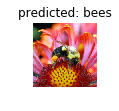

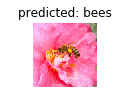

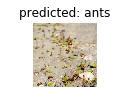

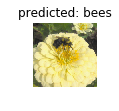

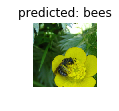

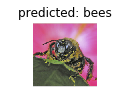

In [10]:
visualize_model(model_ft)

ConvNet as fixed feature extractor
----------------------------------

Here, we need to freeze all the network except the final layer. We need
to set ``requires_grad == False`` to freeze the parameters so that the
gradients are not computed in ``backward()``.

You can read more about this in the documentation
`here <https://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward>`__.




In [11]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

Train and evaluate
^^^^^^^^^^^^^^^^^^

On CPU this will take about half the time compared to previous scenario.
This is expected as gradients don't need to be computed for most of the
network. However, forward does need to be computed.




In [12]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.7223 Acc: 0.6107
val Loss: 0.3490 Acc: 0.8497

Epoch 1/24
----------
train Loss: 0.4673 Acc: 0.7828
val Loss: 0.1719 Acc: 0.9412

Epoch 2/24
----------
train Loss: 0.4296 Acc: 0.7828
val Loss: 0.1645 Acc: 0.9477

Epoch 3/24
----------
train Loss: 0.4958 Acc: 0.7787
val Loss: 0.1982 Acc: 0.9477

Epoch 4/24
----------
train Loss: 0.4782 Acc: 0.7664
val Loss: 0.1843 Acc: 0.9346

Epoch 5/24
----------
train Loss: 0.3832 Acc: 0.8156
val Loss: 0.1799 Acc: 0.9477

Epoch 6/24
----------
train Loss: 0.3573 Acc: 0.8525
val Loss: 0.1928 Acc: 0.9542

Epoch 7/24
----------
train Loss: 0.3926 Acc: 0.8402
val Loss: 0.1929 Acc: 0.9412

Epoch 8/24
----------
train Loss: 0.3672 Acc: 0.8484
val Loss: 0.2243 Acc: 0.9412

Epoch 9/24
----------
train Loss: 0.2576 Acc: 0.8893
val Loss: 0.2175 Acc: 0.9281

Epoch 10/24
----------
train Loss: 0.3026 Acc: 0.8811
val Loss: 0.2169 Acc: 0.9346

Epoch 11/24
----------
train Loss: 0.4203 Acc: 0.8156
val Loss: 0.1810 Acc: 0.9412

Ep

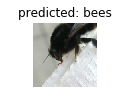

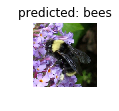

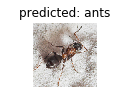

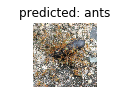

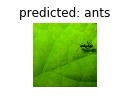

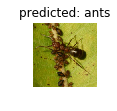

In [13]:
visualize_model(model_conv)

plt.ioff()
plt.show()